# Lecture 4 - Modelling and Analysis Using DynamicalSystems.jl

- [DynamicalSystems.jl](https://juliadynamics.github.io/DynamicalSystems.jl/latest/) is a comprehensive package providing a wide range of utilities for working with dynamical systems and investigating chaos in Julia.


## Contents
1. [The DynamicalSystems.jl Interface](#interface)
2. [Trajectories](#trajectories)
3. [Pre-Defined Dynamical Systems](#pre-defined)
4. [Orbit Diagrams](#orbits)
5. [Lyapunov Exponents](#lyapunov)
6. [Interactive Plotting](#plotting)
7. [Further Reading](#further-reading)
8. [Next Week](#next-week)

In [26]:
using Pkg
Pkg.activate(".") # activate local env 
Pkg.add(["DynamicalSystems","OrdinaryDiffEq", "CairoMakie", "Printf"])
# OrdinaryDiffEq.jl: Component package of DifferentialEquations.jl for solving ODEs
# CairoMakie.jl: Alternative to Plots.jl
# Printf.jl: C style string formatting

  Activating project at `~/Nextcloud/TUM-Dynamics-Lecture/lectures/lecture-4`
   Resolving package versions...
  No Changes to `~/Nextcloud/TUM-Dynamics-Lecture/lectures/lecture-4/Project.toml`
  No Changes to `~/Nextcloud/TUM-Dynamics-Lecture/lectures/lecture-4/Manifest.toml`


In [2]:
using DynamicalSystems, CairoMakie

## 1. The DynamicalSystems.jl Interface <a class="anchor" id="types"></a>


- As you know, a dynamical system can be either continuous in time, 

$$\frac{du}{dt} = f(u, p, t),$$

or discrete (a map),

$$u_{n+1} = f(u_n, p, n),$$

where $u \in \mathbb{R}^n$ is the state of the system, $p \in \mathbb{R}^m$ are the parameters of the system, and the function $f:\mathbb{R}^n \times \mathbb{R} \to \mathbb{R}^n$ is the "dynamic rule" describing the equations of motion of the dynamical system.


- Given some system, continuous or discrete, with dynamic rule $f$, DynamicalSystems.jl implements the abstract data type `DynamicalSystem` to describe such a system.
<br>

- The Julia function `f` implementing the dynamic rule $f$ may be defined either **in-place** or **out-of-place**. 

### 1.1. Out-of-place (OOP) Dynamic Rule


- Out-of-place `f` is more efficient for **small systems** and requires a function signature of the form 

    ```f(u, p, t) -> SVector``` 
    
where `SVector` is a static array type (its size can't change after it's been created) from the [StaticArrays.jl](https://github.com/JuliaArrays/StaticArrays.jl) library.  


#### Example 1: Hénon Map (Discrete, Out-of-Place)

- The [Hénon Map](https://en.wikipedia.org/wiki/H%C3%A9non_map) is a classic discrete-time dynamical system which exhibits chaotic behaviour. It was developed as a simplified discrete-time analogue of the Lorenz system.

$$\begin{aligned}
x_{n+1} &= 1 - ax^2_n+y_n \\
y_{n+1} & = bx_n
\end{aligned}$$

In [3]:
function f_henon(u, p, n)
    xₙ, yₙ = u
    a, b = p
    return SVector{2}(1 - a * xₙ^2 + yₙ, b * xₙ)
end

f_henon (generic function with 1 method)

In [4]:
u = rand(2)
p = [1.4, 0.3]
henon = DeterministicIteratedMap(f_henon, u, p)

2-dimensional DeterministicIteratedMap
 deterministic: true
 discrete time: true
 in-place:      false
 dynamic rule:  f_henon
 parameters:    [1.4, 0.3]
 time:          0
 state:         [0.1347809235441978, 0.3074720837855429]


In [5]:
DeterministicIteratedMap <: DynamicalSystem

true

### 1.2. In-place (IIP) Dynamic Rule

- In-place `f` is more efficient for **large systems** and requires a function signature of the form

    `f!(du, u, p, t) -> nothing`<br><br>
    
    
- Typically, the in-place formulation begins to outperform the out-of-place formulation around $n = 10$.


#### Example 2: Lorenz System (Continous, In-Place)

- The [Lorenz system](https://en.wikipedia.org/wiki/Lorenz_system), which you saw in the first part of today's lecture, has the equations of motion

$$
\begin{aligned} 
\dot{x} &= \sigma(y-x) \\ 
\dot{y} &= x(\rho-z)  -y \\ 
\dot{z} &= xy - \beta z 
\end{aligned}
$$

In [6]:
function f_lorenz63!(du, u, p, t)
    x, y, z = u
    σ, ρ, β = p
    
    du[1] = σ * (y - x)
    du[2] = x * (ρ - z) - y
    du[3] = x * y - β * z
    
    return nothing
end

f_lorenz63! (generic function with 1 method)

In [7]:
lorenz63 = CoupledODEs(f_lorenz63!, rand(3), [10.0, 28.0, 8/3])

3-dimensional CoupledODEs
 deterministic: true
 discrete time: false
 in-place:      true
 dynamic rule:  f_lorenz63!
 ODE solver:    Tsit5
 ODE kwargs:    (abstol = 1.0e-6, reltol = 1.0e-6)
 parameters:    [10.0, 28.0, 2.6666666666666665]
 time:          0.0
 state:         [0.801932398051682, 0.5382188986475425, 0.04730164003293946]


- As you can see, the specific constructor you need to use depends on whether your system is discrete (`DeterministicIteratedMap`) or continuous (`CoupledODEs`).
<br>

- Both `DeterministicIteratedMap` and `CoupledODEs` are subtypes of `DynamicalSystem`.
<br>

- The constructors will automatically detect from the function signature whether you have provided an in-place or out-of-place method for the dynamic rule.

## 2. Trajectories <a class="anchor" id="trajectories"></a>

- Given an instance of a (concrete subtype of) `DynamicalSystem`, it is then incredibly straightforward to compute trajectories with the `trajectory` function.

In [8]:
traj = trajectory(henon, 10)  # Integrate the discrete system for 10 iterations

(2-dimensional StateSpaceSet{Float64} with 11 points, 0:1:10)

In [9]:
traj[1]

2-dimensional StateSpaceSet{Float64} with 11 points
  0.134781    0.307472
  1.28204     0.0404343
 -1.26064     0.384612
 -0.840295   -0.378193
 -0.366726   -0.252088
  0.559629   -0.110018
  0.451524    0.167889
  0.882465    0.135457
  0.0452156   0.264739
  1.26188     0.0135647
 -1.2157      0.378563

In [10]:
traj = trajectory(lorenz63, 50, Δt = 0.1)  # Integrate the continuous system for 10 seconds with timesteps of 0.1s

(3-dimensional StateSpaceSet{Float64} with 501 points, 0.0:0.1:50.0)

In [11]:
traj[1]

3-dimensional StateSpaceSet{Float64} with 501 points
   0.801932     0.538219   0.0473016
   1.50818      3.1623     0.207806
   4.74493     10.1867     1.89812
  13.6401      25.5322    16.3149
  18.7249      10.32      48.0773
   4.14886     -9.109     35.6501
  -4.11738     -8.50456   27.9773
  -6.81498     -8.52629   25.6517
  -8.2528      -9.52102   25.6802
  -9.27183     -9.92057   27.3056
  -9.35119     -8.84754   28.7323
  -8.4747      -7.41459   28.3344
  -7.60133     -7.0507    26.6836
   ⋮                      
 -11.6233      -4.969     37.2104
  -4.93833      0.277797  29.6883
  -1.72454     -0.15592   22.6816
  -1.07112     -1.08923   17.4383
  -1.54746     -2.48979   13.5517
  -3.16348     -5.65515   11.1947
  -7.11164    -12.8169    12.6871
 -14.0455     -20.5243    26.5696
 -14.1919      -6.9348    40.8172
  -5.12225      2.7067    32.2185
  -0.0748287    2.73138   24.1532
   1.77754      3.17883   18.7547

- DynamicalSystems.jl uses the ODE solvers from DifferentialEquations.jl "under the hood" to integrate trajectories of continuous dynamical systems.
<br>

- By default, the `Tsit5()` solver is used with `abstol` and `reltol` equal to `1e-6`. 
<br>

- For more control over the ODE solver, pass the `diffeq` keyword argument with a [named tuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) to the `CoupledODEs` constructor.

In [12]:
using OrdinaryDiffEq  # Need to import this if we want to specify a solver algorithm

lorenz63 = ContinuousDynamicalSystem(
    f_lorenz63!, 
    rand(3), 
    [10.0, 28.0, 8/3], 
    diffeq = (alg = Vern9(), abstol = 1e-12, reltol = 1e-12)  # Override defaults
)

trajectory(
    lorenz63, 
    50, 
    Δt = 0.1, 
)

(3-dimensional StateSpaceSet{Float64} with 501 points, 0.0:0.1:50.0)

## 3. Pre-Defined Dynamical Systems <a class="anchor" id="pre-defined"></a>

- In fact, DynamicalSystems.jl also provides a huge number of pre-defined dynamical systems, making the process of setting up and integrating trajectories of dynamical systems even easier still.

In [13]:
ds = Systems.lorenz()  # Lorenz system with default parameters

3-dimensional CoupledODEs
 deterministic: true
 discrete time: false
 in-place:      false
 dynamic rule:  lorenz_rule
 ODE solver:    Tsit5
 ODE kwargs:    (abstol = 1.0e-6, reltol = 1.0e-6)
 parameters:    [10.0, 28.0, 2.6666666666666665]
 time:          0.0
 state:         [0.0, 10.0, 0.0]


In [14]:
trajectory(ds, 10, Δt = 0.1)[1]

3-dimensional StateSpaceSet{Float64} with 101 points
  0.0      10.0       0.0
  8.92478  19.6843    6.02839
 20.0553   24.8278   39.9785
  9.89834  -7.67213  42.312
 -2.67297  -9.86486  30.4531
 -6.73013  -8.71064  27.4841
 -7.91     -8.6127   26.6731
 -8.44188  -8.84913  26.7275
 -8.72491  -8.86503  27.1909
 -8.70356  -8.53165  27.5098
 -8.44777  -8.15714  27.3383
 -8.22042  -8.09542  26.8448
 -8.23684  -8.3923   26.4873
  ⋮                  
 -9.02117  -8.73059  28.0281
 -8.50876  -7.87543  27.8401
 -7.9705   -7.61641  26.849
 -7.90031  -8.12215  25.9823
 -8.35258  -8.96853  25.9951
 -8.94423  -9.40349  26.9656
 -9.09671  -8.90393  27.9988
 -8.62374  -7.96528  28.0069
 -8.01075  -7.5485   27.038
 -7.8329   -7.96259  26.0287
 -8.23296  -8.84597  25.8467
 -8.879    -9.44531  26.7382

- With just two lines of code, we can get a trajectory for a wide range of pre-defined dynamical systems!

## 4. Orbit Diagrams <a class="anchor" id="orbits"></a>

- In the first exercise you plotted the famous orbit diagram of the [logistic map](https://en.wikipedia.org/wiki/Logistic_map),

$$x_{n+1} = rx_n(1-x_n).$$


- Let's see how we could do this using the `orbitdiagram` function of DynamicalSystems.jl.

In [15]:
ds = Systems.logistic()  # Logistic map with default parameters

# Params for orbitdiagram function
i = 1                   # Number of variables to save (logistic map only has one variable)
p_index = 1             # Index of the parameter to vary (logistic map only has one parameter)
p_values = 2.8:0.005:4  # Values of the parameter r at which to compute the orbits
n_points = 2000         # Number of points to save for each parameter value
transient_steps = 2000  # Number of transient steps (output is only saved after this many steps have elapsed)

output = orbitdiagram(ds, i, p_index, p_values, n = n_points, Ttr = transient_steps);

In [16]:
j = 140
println("r = $(p_values[j])")
output[j]

r = 3.495


2000-element Vector{Float64}:
 0.8737323574766116
 0.38558281678753487
 0.8279959351091096
 0.4977532395988931
 0.8737323574766117
 0.38558281678753453
 0.8279959351091093
 0.49775323959889395
 0.8737323574766116
 0.38558281678753487
 0.8279959351091096
 0.4977532395988931
 0.8737323574766117
 ⋮
 0.8737323574766117
 0.38558281678753453
 0.8279959351091093
 0.49775323959889395
 0.8737323574766116
 0.38558281678753487
 0.8279959351091096
 0.4977532395988931
 0.8737323574766117
 0.38558281678753453
 0.8279959351091093
 0.49775323959889395

- Even better, let's plot it!

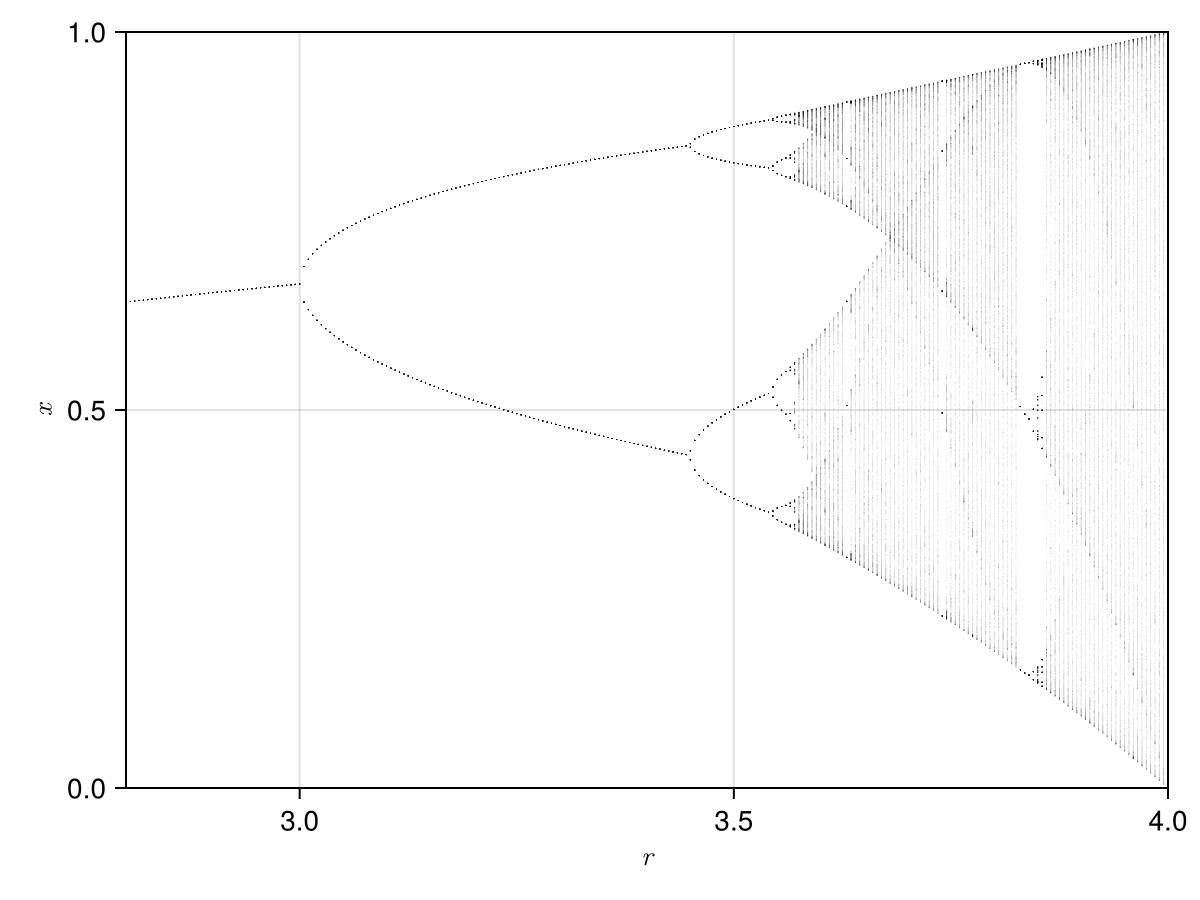

In [17]:
fig = CairoMakie.Figure()
ax = Axis(fig[1, 1], xlabel = L"r", ylabel = L"x")

for j in eachindex(p_values)
    scatter!(
        ax,
        fill(p_values[j], n_points),
        output[j];
        markersize = 0.8, 
        color = ("black", 0.05),
    )
end
xlims!(ax, p_values[1], p_values[end])
ylims!(ax, 0, 1)
fig

## 5. Lyapunov Exponents <a class="anchor" id="lyapunov"></a>

### 5.1. The Largest Lyapunov Exponent

- You saw earlier that the Lyapunov exponent measures the exponential divergence of trajectories which are initially close together in phase space.
<br>

- Consider some state $\mathbf x(t)$ of a chaotic dynamical system. At time $t = 0$ we obtain a nearby state by perturbing the original state $\mathbf x_0$ by a small amount $\mathbf y_0$, such that the nearby state evolves as $\mathbf x(t) + \mathbf y(t)$. The initial distance between the two states is then given by $\delta_0 = ||\mathbf y_0||$.
<br>

- The distance between the two trajectories will evolve approximately as

$$\delta(t) \approx \delta_0 \exp (\lambda_1 t),$$

where $\lambda_1$ is the **largest Lyapunov exponent**.

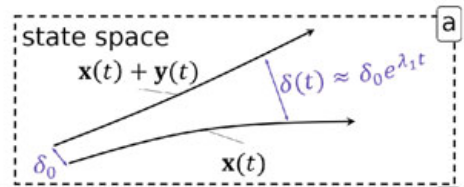
[Source](https://link.springer.com/book/10.1007/978-3-030-91032-7)


- To compute the largest Lyapunov exponent, we could simply integrate this system until $\delta(t)$ reaches some pre-defined upper or lower threshold at time $T$, and estimate the maximum Lyapunov exponent as

$$\lambda_{max} \approx \frac{1}{T} \ln \left( \frac{\delta (T)}{\delta_0} \right).$$


- In practice, this will yield a very noise estimate for $\lambda_{max}$. To obtain a better estimate, every time the separation $\delta(t)$ reaches the upper or lower separation threshold, we can store the time $t_i$ at which this happens and then rescale the perturbed trajectory back to the initial separation $\delta_0$, before repeating the procedure. 
<br>

- Our improved estimate for the largest Lyapunov exponent is then

$$\lambda_{max} \approx \frac{1}{t_n - t_0} \sum_{i = 1}^{n} \ln \left( \frac{\delta (t_i)}{\delta_0} \right).$$



- DynamicalSystems.jl implements this routine using the `lyapunov` function.

In [18]:
# Maximum Lyapunov exponent of the Hénon map we defined earlier

lyapunov(henon, 10000, u0=rand(2))

0.42011627055719275

In [19]:
# Maximum Lyapunov exponent of the Lorenz system we defined earlier
lorenz = Systems.lorenz()
lyapunov(lorenz, 10000) 

0.9041733523645664

In [20]:
using Printf
@time for i in 1:7
    T = 10^i
    λ = lyapunov(lorenz, T)
    @printf "T = %7is, λ = %f \n" T λ
end

T =      10s, λ = -0.049912 
T =     100s, λ = 0.695000 
T =    1000s, λ = 0.883228 
T =   10000s, λ = 0.904173 
T =  100000s, λ = 0.905651 
T = 1000000s, λ = 0.905800 
T = 10000000s, λ = 0.905628 
150.482850 seconds (11.46 M allocations: 568.729 MiB, 0.06% gc time, 0.11% compilation time)


- We will often use the *Lyapunov time*, $\tau = 1 / \lambda_{max}$, as a characteristic timescale for a chaotic system:

$$\delta(t) \approx \delta_0 \exp (t / \tau)$$

### 5.2. The Lyapunov Spectrum

- More generally, for an $n$-dimensional system, we can compute $n$ Lyapunov exponents. These exponents are known collectively as the **Lyapunov spectrum**, and are usually given in decreasing order, 

$$\lambda_1 \geq \lambda_2 \geq \ldots \geq \lambda_n.$$


- Instead of considering a single perturbation to the initial state $\mathbf x_0$, we can consider instead an infinitesimal volume of perturbed initial conditions around $\mathbf x_0$. We thus have an $n$-dimensional hypersphere around $\mathbf x_0$ with an initial radius $\delta$.
<br>

- As this system evolves, the initial hypersphere will be deformed into a hyperellipsoid, as the trajectories diverge (or converge) more rapidly in certain directions.
<br>

- In fact, the $i$-th axis of the ellipsoid will grow as $\delta \exp{(\lambda_i t)}$. 

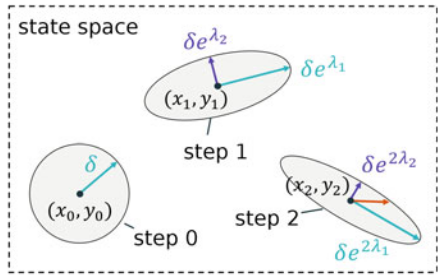
[Source](https://link.springer.com/book/10.1007/978-3-030-91032-7)

- The procedure for computing the Lyapunov spectrum is conceptually similar to the one we described earlier for computing the largest Lyapunov exponent, albeit more complicated.
<br>

- To compute the full Lyapunov spectrum of a a dynamical system, use the function `lyapunovspectrum` from DynamicalSystems.jl

In [21]:
# Lyapunov spectrum of the Hénon map we defined earlier
lyapunovspectrum(henon, 1000)

2-element Vector{Float64}:
  0.4092927014852484
 -1.6132655058111836

In [22]:
# Lyapunov spectrum of the Lorenz system we defined earlier
lyapunovspectrum(lorenz, 10000)

3-element Vector{Float64}:
   0.9029433590713206
   7.814632658253149e-5
 -14.569605074625649

- See how easy it is to compute Lyapunov exponents this way? With just two lines of code we can compute the full Lyapunov spectrum!

In [23]:
ds = Systems.lorenz()
lyapunovspectrum(ds, 10000)

3-element Vector{Float64}:
   0.9029433590713206
   7.814632658253149e-5
 -14.569605074625649

## 6. Interactive Plotting <a class="anchor" id="plotting"></a>

- DynamicalSystems.jl also provides some great interactive utilities via the package [InteractiveDynamics.jl](https://juliadynamics.github.io/InteractiveDynamics.jl/dev/) for exploring dynamical systems and chaos.

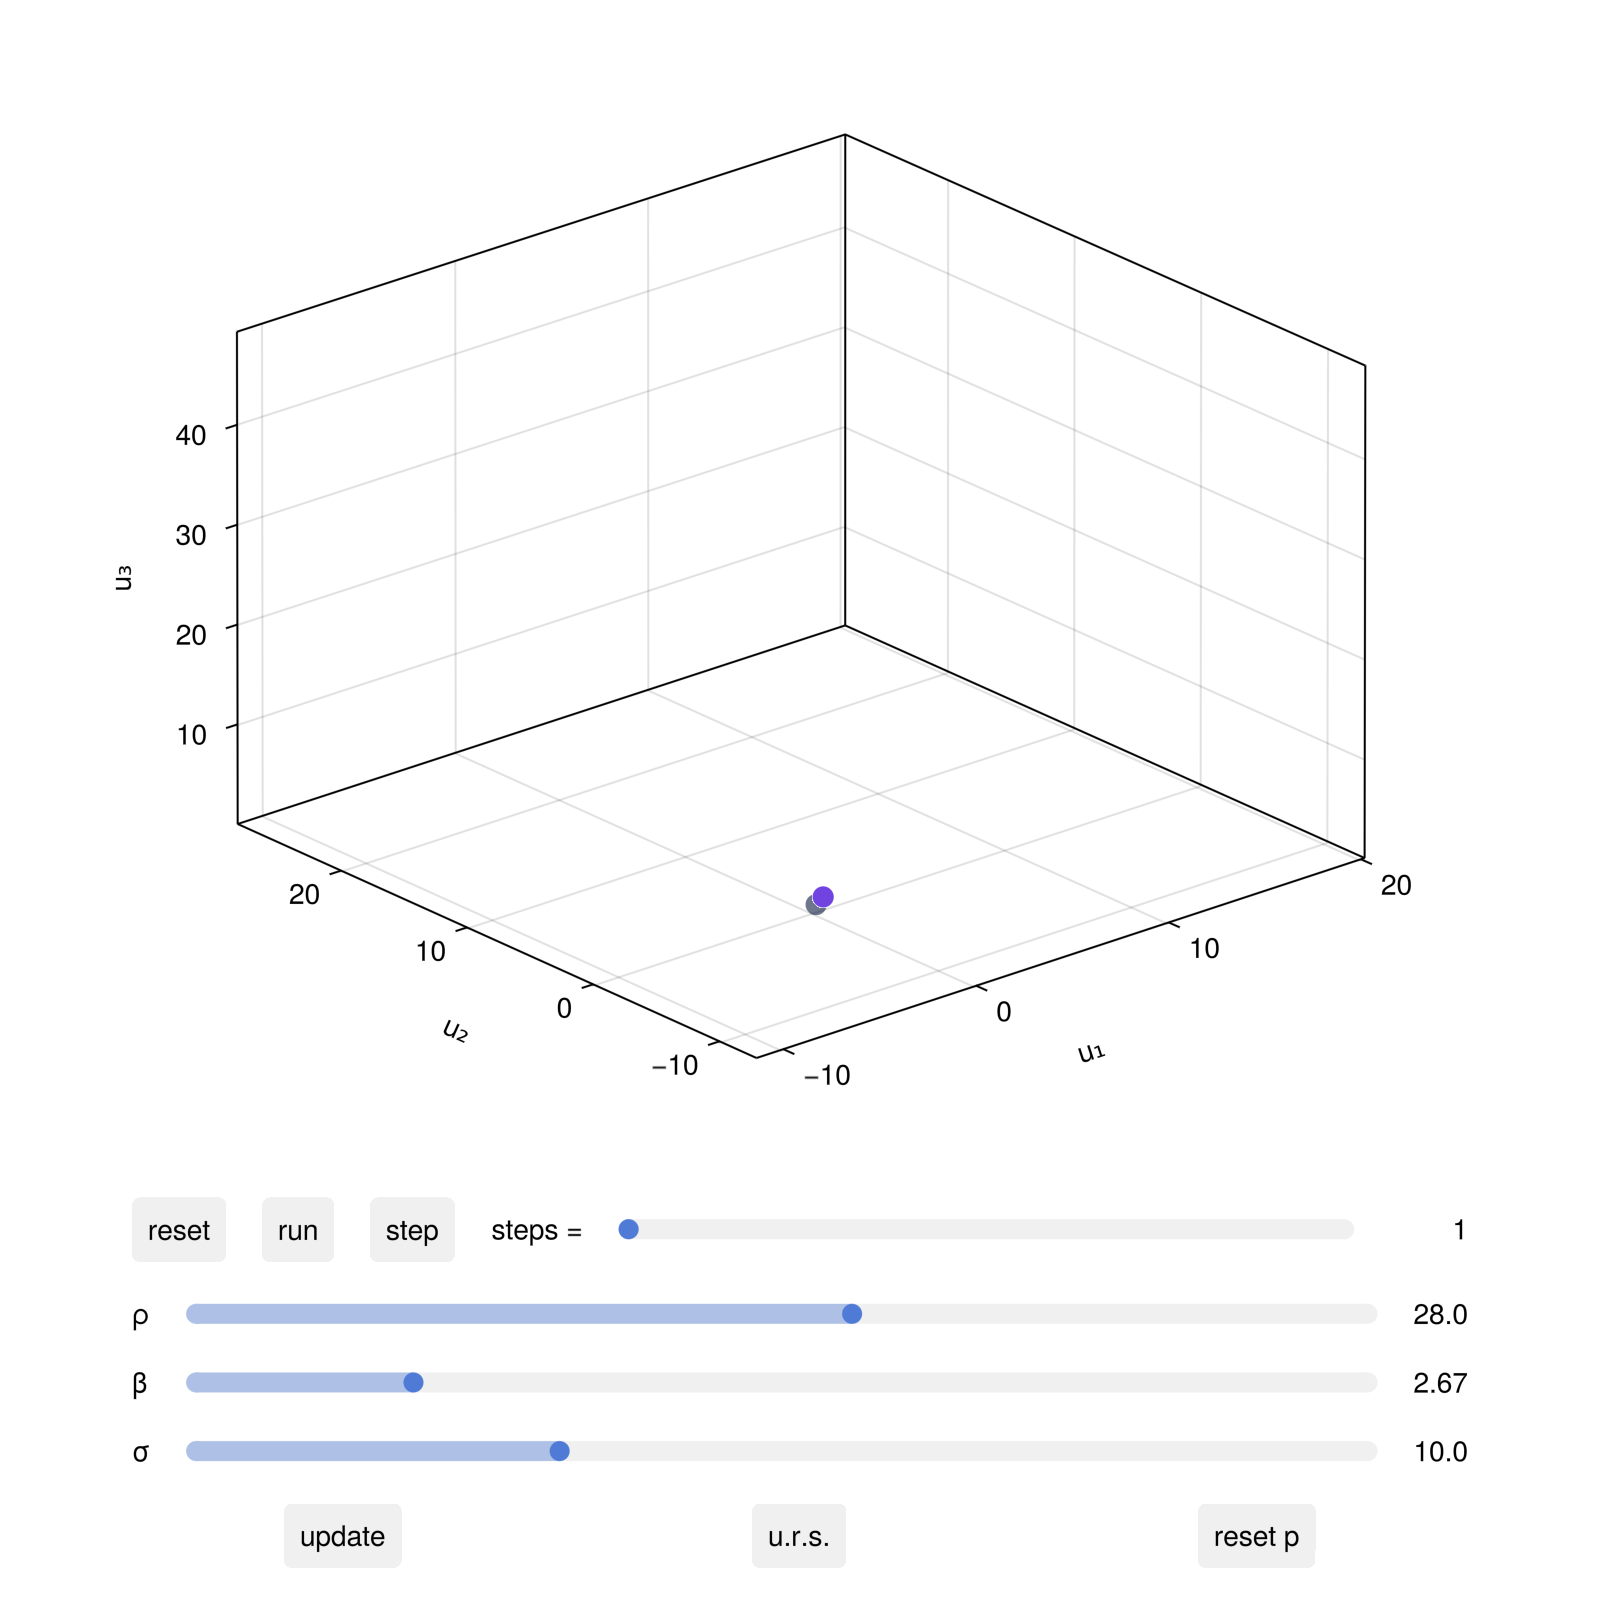

In [24]:
# Run this in VSCode!
using DynamicalSystems
using OrdinaryDiffEq
using GLMakie

lorenz = Systems.lorenz()

parameter_sliders = Dict(
    1 => 1:0.1:30,
    2 => 0:0.1:50,
    3 => 1:0.01:10.0,
)
parameter_names = Dict(1 => "σ", 2 => "ρ", 3 => "β")

fig, dsobs = interactive_trajectory(lorenz, [rand(3), rand(3)]; add_controls=true, parameter_sliders, parameter_names)
fig

In [25]:
# Run this in VSCode!
using DynamicalSystems
using OrdinaryDiffEq
using GLMakie

henon = Systems.henon()

i = 1                    # First variable
p_index = 1              # First parameter
p_min, p_max = 0.8, 1.4  # Min,max value of parameter

title = "Orbit Diagram for the Hénon map"

interactive_orbitdiagram(henon, p_index, p_min, p_max, i, parname = "a", title = title)

LoadError: UndefVarError: `InteractiveDynamics` not defined

See the [docs](https://juliadynamics.github.io/DynamicalSystems.jl/dev/visualizations/) for many more options!

## 7. Further Reading <a class="anchor" id="further-reading"></a>

1. [DynamicalSystems.jl documentation](https://juliadynamics.github.io/DynamicalSystems.jl/latest/)
2. [Nonlinear Dynamics: A Concise Introduction Interlaced with Code (Datseris & Parlitz 2022)](https://link.springer.com/book/10.1007/978-3-030-91032-7)

## 8. Next Week <a class="anchor" id="next-week"></a>

1. Data-driven analysis using DynamicalSystems.jl.